## Melanoma Detection Using CNNs

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2367 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
data_dir = "/content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir_train = pathlib.Path(data_dir + "/Train")
data_dir_test = pathlib.Path(data_dir + "/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

total_target_labels = 9
epochs_train = 20
epochs_train_final = 30

Use 80% of the images for training, and 20% for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

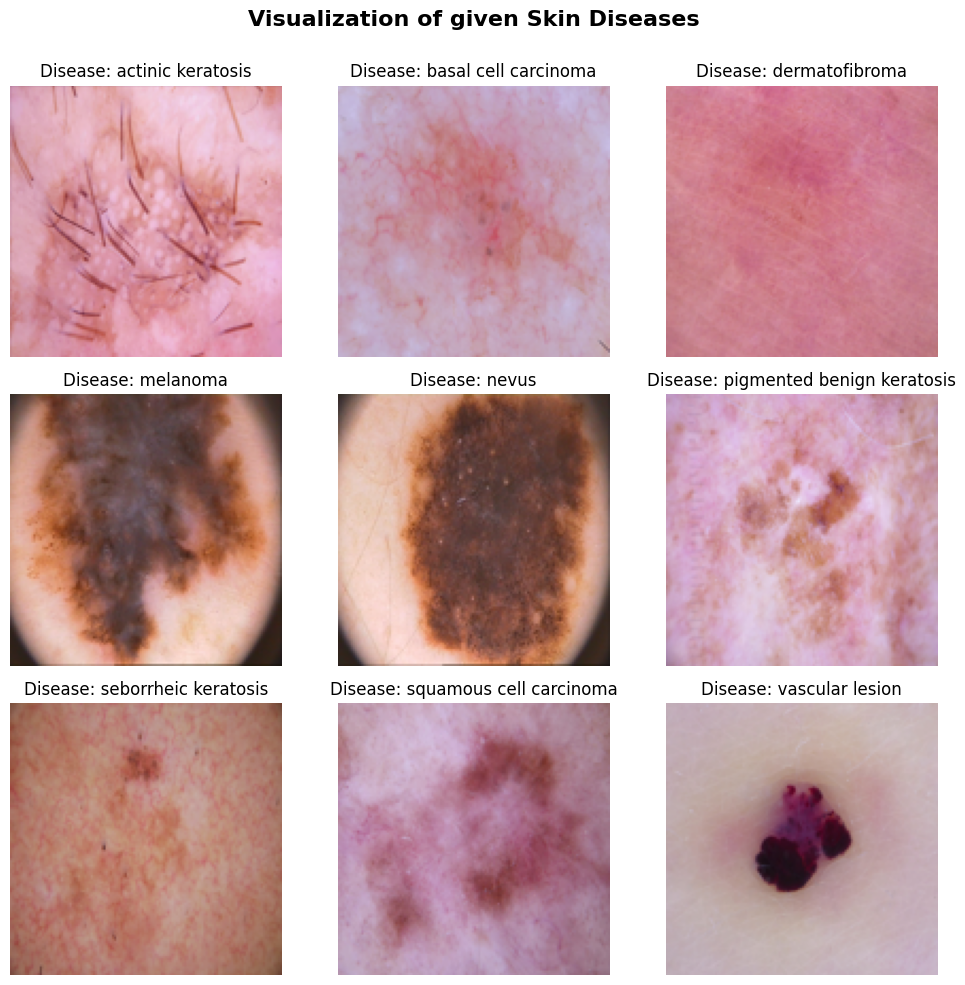

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import random

dataset_path = data_dir_train
target_size = (128, 128)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, folder in enumerate(class_names):
  folder_path = os.path.join(dataset_path, folder)
  image_files = os.listdir(folder_path)
  random_image_file = random.choice(image_files)
  image_path = os.path.join(folder_path, random_image_file)
  img = Image.open(image_path)
  img = img.resize(target_size)
  img_array = np.array(img)
  row = i // 3
  col = i % 3
  axes[row, col].imshow(img_array)
  axes[row, col].set_title(f"Disease: {folder}")
  axes[row, col].axis('off')
fig.suptitle('Visualization of given Skin Diseases\n', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(total_target_labels)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
%%time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_train
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 722s 3s/step - accuracy: 0.2142 - loss: 2.3115 - val_accuracy: 0.3541 - val_loss: 1.8373
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3627 - loss: 1.7738 - val_accuracy: 0.4454 - val_loss: 1.5685
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4774 - loss: 1.4779 - val_accuracy: 0.4722 - val_loss: 1.5116
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5265 - loss: 1.3810 - val_accuracy: 0.5212 - val_loss: 1.4194
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5825 - loss: 1.2430 - val_accuracy: 0.5122 - val_loss: 1.4554
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5892 - loss: 1.1874 - val_accuracy: 0.4989 - val_loss: 1.3281
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6302 - loss: 1.0552 - val_accuracy: 0.5345 - val_loss: 1.3377
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6564 - loss: 0.9892 - val_accuracy: 0.5234 - v

### Visualizing training results

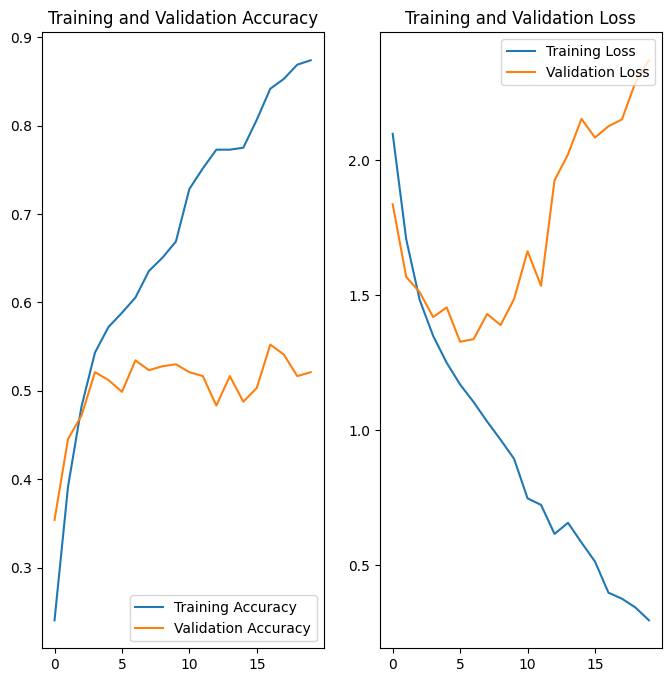

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs_train)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

1.   The model’s training accuracy steadily increases, reaching up to 90%, while the validation accuracy remains consistently around 55%.

2.   The high training accuracy indicates that the model has likely learned the noise in the data, but its poor performance on the validation set points to a lack of generalization.

3.   These findings confirm overfitting is occurring. To resolve this, augmentation techniques will be applied. Since the training data is limited, new samples will be generated by making small alterations to the existing data, such as flipping images horizontally/vertically or rotating them slightly, and these will be used to train the model.



In [16]:
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

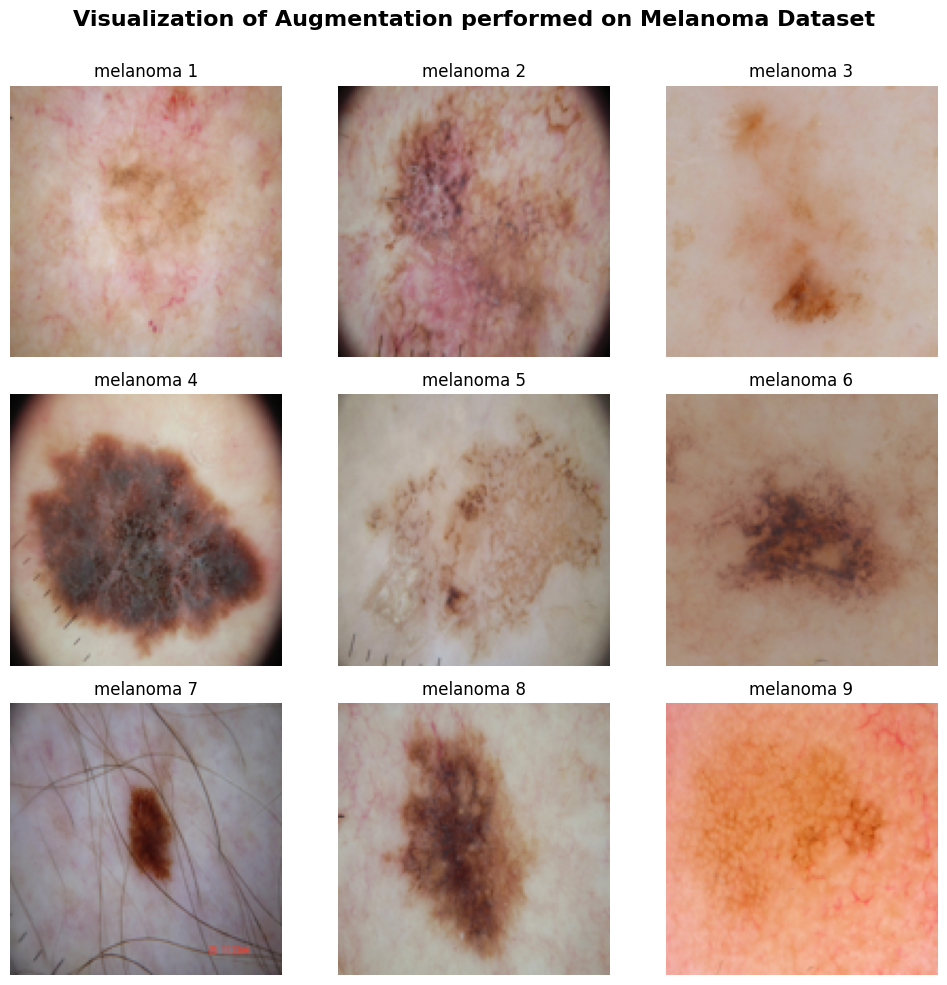

In [17]:
dataset_path = data_dir_train / 'melanoma'
target_size = (128, 128)
image_files = os.listdir(dataset_path)
random_images = random.sample(image_files, 9)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, image_file in enumerate(random_images):
    image_path = os.path.join(dataset_path, image_file)
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    row = i // 3
    col = i % 3
    axes[row, col].imshow(img_array)
    axes[row, col].set_title(f"melanoma {i+1}")
    axes[row, col].axis('off')
fig.suptitle('Visualization of Augmentation performed on Melanoma Dataset\n', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [18]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(total_target_labels)
])

### Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
%%time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_train
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.2166 - loss: 2.0829 - val_accuracy: 0.3697 - val_loss: 1.7176
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3925 - loss: 1.6799 - val_accuracy: 0.3742 - val_loss: 1.6768
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4545 - loss: 1.5322 - val_accuracy: 0.4566 - val_loss: 1.4615
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4871 - loss: 1.4410 - val_accuracy: 0.4833 - val_loss: 1.4079
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5202 - loss: 1.3744 - val_accuracy: 0.4922 - val_loss: 1.4562
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5407 - loss: 1.3476 - val_accuracy: 0.4855 - val_loss: 1.4214
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5540 - loss: 1.2647 - val_accuracy: 0.4967 - val_loss: 1.4454
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5459 - loss: 1.2489 - val_accuracy: 0.5078 - v

### Visualizing the results

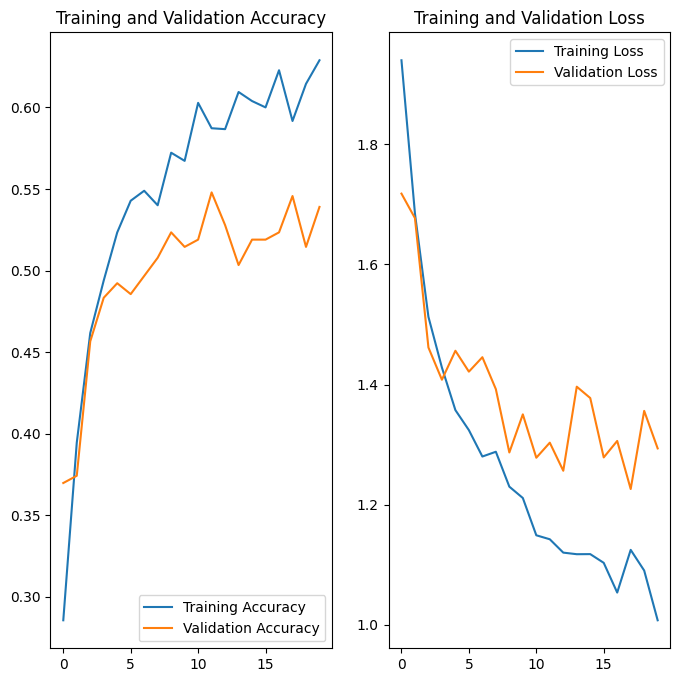

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs_train)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**



1.  The use of augmented data has successfully mitigated overfitting.
2.  The training and validation accuracies of the model mentioned above are within a comparable range.
3.  Both the training and validation datasets are performing poorly, suggesting that the model is currently underfitting.










#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
from glob import glob

images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2249


In [23]:
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0032897.jpg', 'squamous cell carcinoma'), ('/content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0032329.jpg', 'squamous cell carcinoma'), ('/content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0033536.jpg', 'squamous cell carcinoma'), ('/content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0031286.jpg', 'squamous cell carcinoma'), ('/content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaborat

In [24]:
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/Colab Notebooks/Melan...,squamous cell carcinoma
1,/content/gdrive/My Drive/Colab Notebooks/Melan...,squamous cell carcinoma
2,/content/gdrive/My Drive/Colab Notebooks/Melan...,squamous cell carcinoma
3,/content/gdrive/My Drive/Colab Notebooks/Melan...,squamous cell carcinoma
4,/content/gdrive/My Drive/Colab Notebooks/Melan...,squamous cell carcinoma


In [25]:
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,448
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


<ipython-input-26-e7e6fd3a27d0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Label", data=lesions_df, palette='bright')


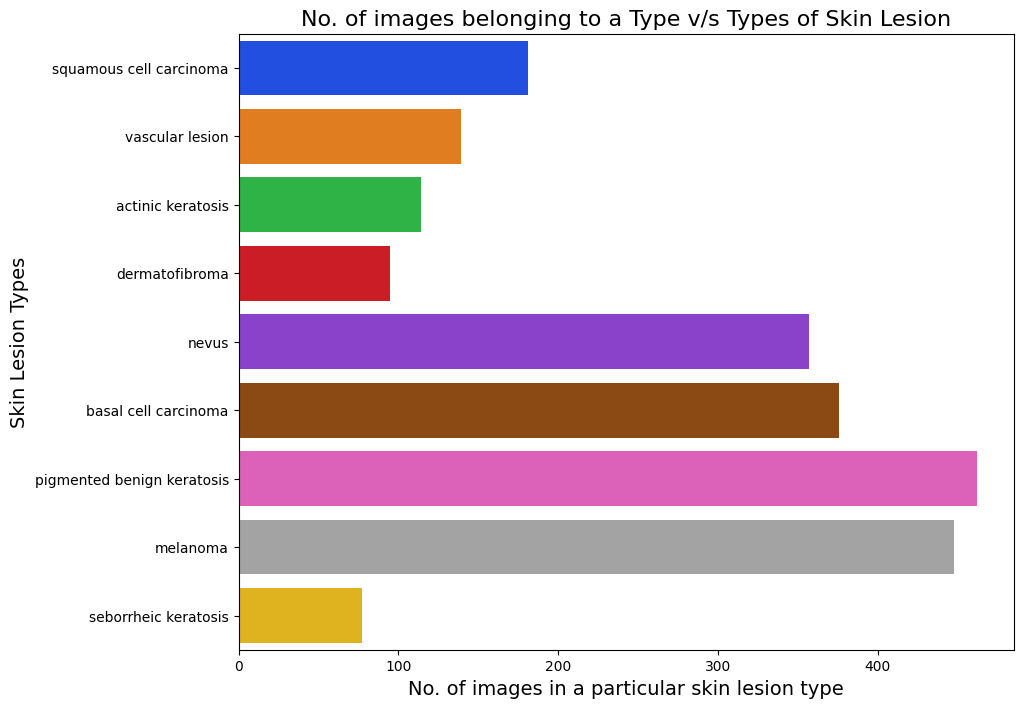

In [26]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df, palette='bright')
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [27]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,20.54
melanoma,19.92
basal cell carcinoma,16.72
nevus,15.87
squamous cell carcinoma,8.05
vascular lesion,6.18
actinic keratosis,5.07
dermatofibroma,4.22
seborrheic keratosis,3.42


**Observations:**


1.   A distinct class imbalance is apparent in the training dataset.
2.   The "seborrheic keratosis" class represents the smallest share of samples, making up about 3.44%.
3.   The "Pigmented benign keratosis" and "melanoma" classes heavily dominate, contributing around 20.63% and 19.56% of the data, respectively.




In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CCEBA464310>: 100%|██████████| 500/500 [00:22<00:00, 22.11 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CCEBA440C10>: 100%|██████████| 500/500 [00:22<00:00, 22.14 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CCEBA452A90>: 100%|██████████| 500/500 [00:19<00:00, 25.90 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CCEBA3489D0>: 100%|██████████| 500/500 [01:14<00:00,  6.74 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7CCFEB04B310>: 100%|██████████| 500/500 [01:07<00:00,  7.42 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CCEBA424410>: 100%|██████████| 500/500 [00:16<00:00, 29.83 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CCED2537790>: 100%|██████████| 500/500 [00:39<00:00, 12.70 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CCECED49310>: 100%|██████████| 500/500 [00:17<00:00, 28.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CCEBA43C490>: 100%|██████████| 500/500 [00:18<00:00, 27.27 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030297.jpg_4f4cbc43-83ac-4cb4-8c32-454e8d366686.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025130.jpg_5e15b0c9-4911-4e7e-9147-991d76c90c0b.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028816.jpg_2c29267b-fd76-4bd7-9ed5-c1b841af2545.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Melanoma Detection CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell car

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma']

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6749, 2)

In [35]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,948
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


In [36]:
round(new_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,14.25
melanoma,14.05
basal cell carcinoma,12.98
nevus,12.70
squamous cell carcinoma,10.09
vascular lesion,9.47
actinic keratosis,9.10
dermatofibroma,8.82
seborrheic keratosis,8.55


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [38]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### Create your model (make sure to include normalization)

In [40]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(total_target_labels)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [42]:
%%time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_train_final
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 239ms/step - accuracy: 0.2940 - loss: 3.1709 - val_accuracy: 0.1045 - val_loss: 28.1625
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 240ms/step - accuracy: 0.4182 - loss: 1.5140 - val_accuracy: 0.1290 - val_loss: 15.4392
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 223ms/step - accuracy: 0.4709 - loss: 1.3717 - val_accuracy: 0.4196 - val_loss: 1.6282
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 235ms/step - accuracy: 0.5061 - loss: 1.2710 - val_accuracy: 0.4537 - val_loss: 1.4389
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 220ms/step - accuracy: 0.5228 - loss: 1.2272 - val_accuracy: 0.3884 - val_loss: 1.6661
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.5412 - loss: 1.2057 - val_accuracy: 0.3158 - val_loss: 1.9686
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.5520 - loss: 1.1583 - val_accuracy: 0.5019 - val_loss: 1.3696
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 232ms/step - accuracy: 0.5737 - loss:

In [43]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,970,301 (45.66 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 7,980,052 (30.44 MB)

#### Visualize the model results

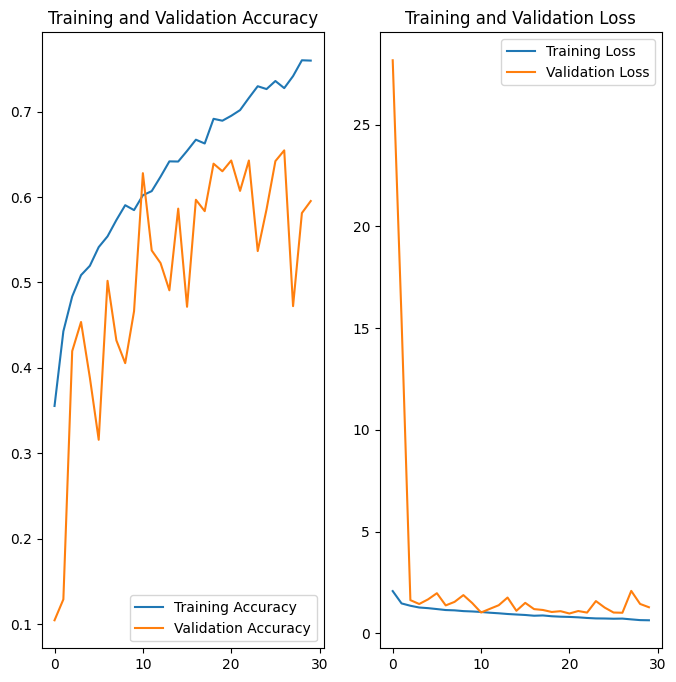

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs_train_final)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**
1.   Introducing batch normalization into the model resulted in a modest increase in both training and validation accuracy.

2.   Designing a different model without batch normalization seeks to explore potential gains in accuracy.








#### Create your model (make sure to remove normalization)

In [45]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(total_target_labels)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [47]:
%%time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_train_final
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.2249 - loss: 2.0810 - val_accuracy: 0.4077 - val_loss: 1.5963
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.4085 - loss: 1.5843 - val_accuracy: 0.4863 - val_loss: 1.4024
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 225ms/step - accuracy: 0.4747 - loss: 1.3620 - val_accuracy: 0.4737 - val_loss: 1.4376
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 221ms/step - accuracy: 0.4980 - loss: 1.3433 - val_accuracy: 0.5367 - val_loss: 1.2455
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 234ms/step - accuracy: 0.5406 - loss: 1.2293 - val_accuracy: 0.5189 - val_loss: 1.2898
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.5500 - loss: 1.1674 - val_accuracy: 0.5693 - val_loss: 1.1423
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.5902 - loss: 1.0918 - val_accuracy: 0.5360 - val_loss: 1.2495
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 236ms/step - accuracy: 0.5867 - loss: 1

In [48]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

#### Visualize the model results

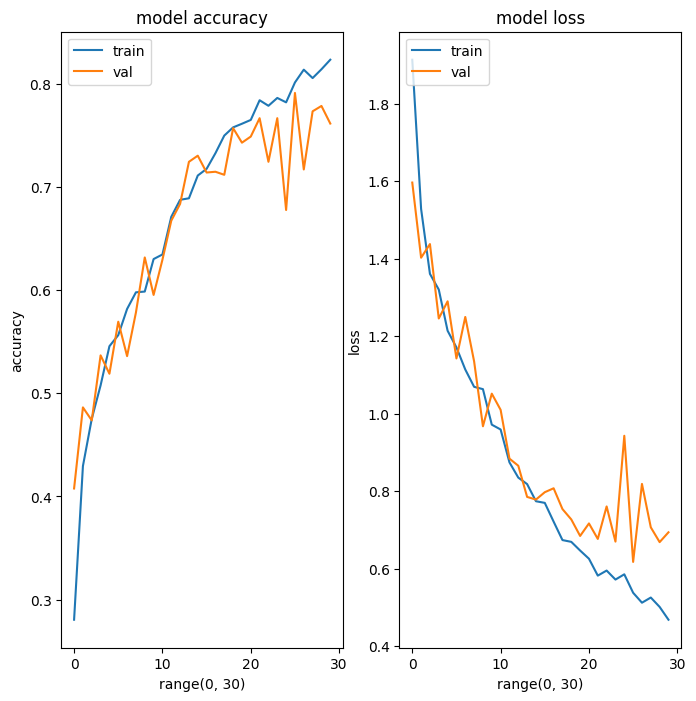

In [49]:
epochs_range = range(epochs_train_final)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Observations:**

1.   The final model demonstrates a strong and balanced performance, showing no indication of either underfitting or overfitting.

2.   The application of class rebalancing has significantly improved the model’s performance on both training and validation sets.

3.   The minimal gap between training and validation accuracies highlights the strong generalization ability of the final CNN model.

4.   The inclusion of batch normalization did not lead to any improvement in training or validation accuracy.